In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [421]:
data = pd.read_csv("../data/super_cleaned_data.csv")
data.shape

(41104, 2)

In [422]:
mapping = {
    'Neutral': 0, 
    'Positive': 1, 
    'Extremely Negative': -1, 
    'Negative': -1, 
    'Extremely Positive': 1
}

X = data.OriginalTweet
y = data.Sentiment
y = y.map(mapping)
# y = pd.Categorical(data.Sentiment)

In [423]:
y.unique()

array([ 0,  1, -1])

In [425]:
tmp = list(set(' '.join(X.tolist()).split(' ')))
print(f"Total unique words are: {len(tmp)}")

Total unique words are: 13025


In [426]:
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5)
X_train = X_train.astype(str)
X_val = X_val.astype(str)
X_test = X_test.astype(str)
print(f"Shape of X_train is: {X_train.shape}, X_val is: {X_val.shape} and X_test is: {X_test.shape}")
print(f"Shape of y_train is: {y_train.shape}, y_val is: {y_val.shape} and y_test is: {y_test.shape}")

Shape of X_train is: (32883,), X_val is: (4110,) and X_test is: (4111,)
Shape of y_train is: (32883,), y_val is: (4110,) and y_test is: (4111,)


In [427]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import torch

MAX_WORDS = 13025
tokenizer = Tokenizer(num_words=MAX_WORDS, char_level=False, split=' ')
tokenizer.fit_on_texts(X_train)

In [428]:
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [429]:
seq_lens = [len(x) for x in X_train]
print(f"Maximum length of sequence is: {max(seq_lens)}")
print(f"Mean length of the sequence is at word level: {np.mean(seq_lens):.4f}")

Maximum length of sequence is: 59
Mean length of the sequence is at word level: 22.9462


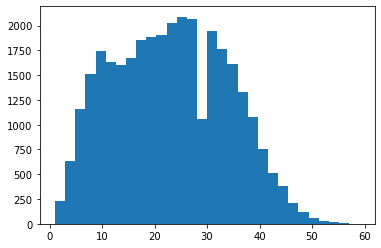

In [430]:
plt.hist(seq_lens, bins=30);

In [431]:
MAX_SEQUENCE_LENGTH = 60

X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, dtype='float32', padding='post')
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH, dtype='float32', padding='post')
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, dtype='float32', padding='post')
print(f"Shape of X_train is: {X_train.shape}, X_val is: {X_val.shape} and X_test is: {X_test.shape}")

Shape of X_train is: (32883, 60), X_val is: (4110, 60) and X_test is: (4111, 60)


In [432]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

labelEncoder = LabelEncoder()
labelEncoder.fit(y_train)


y_train = labelEncoder.transform(y_train)
y_test = labelEncoder.transform(y_test)
y_val = labelEncoder.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)


print(f"Shape of y_train is: {y_train.shape}, y_val is: {y_val.shape} and y_test is: {y_test.shape}")

Shape of y_train is: (32883, 3), y_val is: (4110, 3) and y_test is: (4111, 3)


## Basic Neural network

In [435]:
X_train_basic = (X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train))
X_val_basic = (X_val - np.min(X_val))/(np.max(X_val) - np.min(X_val))
X_test_basic = (X_test - np.min(X_test))/(np.max(X_test) - np.min(X_test))

In [436]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [440]:
test_model = Sequential()
test_model.add(Dense(2048, activation='relu', input_shape=(X_train.shape[1],)))
test_model.add(Dense(1024, activation='relu'))
test_model.add(Dropout(0.2))
test_model.add(Dense(1024, activation='relu'))
test_model.add(Dense(512, activation='relu'))
test_model.add(Dense(256, activation='relu'))
test_model.add(Dense(3, activation='softmax'))

# uncomment the line below to compile the model

test_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [441]:
test_model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_160 (Dense)           (None, 2048)              124928    
                                                                 
 dense_161 (Dense)           (None, 1024)              2098176   
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_162 (Dense)           (None, 1024)              1049600   
                                                                 
 dense_163 (Dense)           (None, 512)               524800    
                                                                 
 dense_164 (Dense)           (None, 256)               131328    
                                                                 
 dense_165 (Dense)           (None, 3)               

In [442]:
# uncomment the line below to run the model

test_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1, batch_size=32, verbose=True)

Epoch 1/3
1028/1028 [==============================] - 38s 36ms/step - loss: 3.9620 - accuracy: 0.4042 - val_loss: 1.0266 - val_accuracy: 0.4341
Epoch 2/3
1028/1028 [==============================] - 43s 42ms/step - loss: 1.0562 - accuracy: 0.4258 - val_loss: 1.0342 - val_accuracy: 0.4333
Epoch 3/3
1028/1028 [==============================] - 43s 41ms/step - loss: 1.0483 - accuracy: 0.4275 - val_loss: 1.0192 - val_accuracy: 0.4358


In [443]:
# uncomment the line below to evaluate the model

test_model.evaluate(X_test, y_test)

129/129 [==============================] - 1s 5ms/step - loss: 1.0278 - accuracy: 0.4318


[1.0278139114379883, 0.43176841735839844]

Basic neural network model gave the accuracy of `43.17%` over the training dataset for 3 classes. For 5 classes, the accuracy was hovering around `29%`.

This model is not performing very well. It starts getting overfit when the network is expanded horizontally and underfits if the network is given the depth. I could'nt understand the issue in this.

## Using the embedding layer in Neural network

In [375]:
from tensorflow.keras.layers import Dense, Embedding, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential

In [444]:
EMBEDDING_DIM = 50
N_CLASSES = 3

embedding_model = Sequential()
embedding_model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32'))
embedding_model.add(Embedding(MAX_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))
embedding_model.add(GlobalAveragePooling1D())
embedding_model.add(Dense(256, activation='relu'))
embedding_model.add(Dropout(0.2))
embedding_model.add(Dense(128, activation='relu'))
embedding_model.add(Dense(64, activation='relu'))
embedding_model.add(Dense(N_CLASSES, activation='softmax'))
embedding_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [445]:
embedding_model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 60, 50)            651250    
                                                                 
 global_average_pooling1d_1  (None, 50)                0         
 5 (GlobalAveragePooling1D)                                      
                                                                 
 dense_166 (Dense)           (None, 256)               13056     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_167 (Dense)           (None, 128)               32896     
                                                                 
 dense_168 (Dense)           (None, 64)                8256      
                                                     

In [449]:
embedding_model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val), verbose=True)

1028/1028 [==============================] - 4s 4ms/step - loss: 0.2447 - acc: 0.9095 - val_loss: 0.6734 - val_acc: 0.8063


In [450]:
embedding_model.evaluate(X_test, y_test)

129/129 [==============================] - 0s 1ms/step - loss: 0.6554 - acc: 0.8161


[0.6554136872291565, 0.8161031603813171]

The embedding model gave good accuracy when trained over a subset of 5000 training sample. Now we will run it for complete training data.

1. When the dimensions were set to 20, there was overfitting just after 6 epochs. The test accuracy achieved was `62%`. Possible reasons can be that the dimension space is too large.
2. With an embedding size of 50, we did prevented overfitting and stopped after 6 epochs (elbow noticed). The accuracy over test data is `64%`. We can further reduce the dimensions.
3. With an embedding dimension of 20, we achieved an accuracy of `65.16%` over the test data.
4. With an embedding dimension of 10, we achieved an accuracy of `64.91%` over the test data.
5. A strange phenomena, if we add 2 dense layers after the pooling layer the accuracy over the test data jumps to `67.63%`.
6. When adding 2 dense layers, first expanding the dimension (128) and then a 16 node layer, the accuracy over the test data is `68.75%`.
7. This is the best accuracy over the test data: `81.61%`. We had to reduce the number of classes from 5 to 3.

## RNN

In [452]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, GlobalMaxPool1D

In [456]:
EMBEDDING_DIM = 20
units = 256

rnn_model = Sequential()
rnn_model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_shape=(X_train.shape[1],)))
rnn_model.add(Bidirectional(LSTM(units, return_sequences=True)))
rnn_model.add(GlobalMaxPool1D())
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(3, activation='softmax'))

rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [457]:
rnn_model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 60, 20)            260500    
                                                                 
 bidirectional_1 (Bidirecti  (None, 60, 512)           567296    
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 512)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_172 (Dense)           (None, 64)                32832     
                                                                 
 dropout_12 (Dropout)        (None, 64)              

In [458]:
history_rnn = rnn_model.fit(X_train[:10000,:], y_train[:10000,:], batch_size = 32, epochs = 5, validation_data=(X_val, y_val))

Epoch 1/5
313/313 [==============================] - 51s 153ms/step - loss: 0.9248 - acc: 0.5292 - val_loss: 0.7191 - val_acc: 0.7044
Epoch 2/5
313/313 [==============================] - 49s 158ms/step - loss: 0.5818 - acc: 0.7804 - val_loss: 0.5885 - val_acc: 0.7703
Epoch 3/5
313/313 [==============================] - 50s 159ms/step - loss: 0.4169 - acc: 0.8533 - val_loss: 0.6046 - val_acc: 0.7727
Epoch 4/5
313/313 [==============================] - 53s 169ms/step - loss: 0.3244 - acc: 0.8962 - val_loss: 0.6554 - val_acc: 0.7747
Epoch 5/5
313/313 [==============================] - 52s 167ms/step - loss: 0.2542 - acc: 0.9183 - val_loss: 0.7550 - val_acc: 0.7676


In [459]:
rnn_model.evaluate(X_test, y_test)

129/129 [==============================] - 5s 37ms/step - loss: 0.7350 - acc: 0.7760


[0.7349579334259033, 0.7759669423103333]